In [31]:
import math
import time
import matplotlib.pyplot as plt
import torch
import trimesh

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
import torch.nn.functional as F
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.mesh_renderer import MeshPointsRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list
torch.set_printoptions(sci_mode=False
)

In [35]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 512
config.raster_radius = 0.012
config.raster_points_per_pixel = 4
    
d_size = 2048
config.data_blueprint = f'blueprint_radial_{d_size}.npz'
config.data_blueprint_size = d_size
config.data_patch_size = d_size // 8
config.raster_max_brightness = 0.9
#parser.add_argument('--raster_blur_radius', type=float, default=0.01)
#parser.add_argument('--raster_faces_per_pixel', type=int, default=4)

blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 65536, 3]),
 torch.Size([1, 65536, 3]),
 torch.Size([1, 130050, 3]))

In [36]:
config.raster_blur_radius = 0.0
config.raster_faces_per_pixel = 4
R = MeshPointsRenderer(config)
R.setup(device)
R = R.to(device)

In [37]:
print(points.shape)

torch.Size([1, 65536, 3])


torch.Size([1, 512, 512, 4])


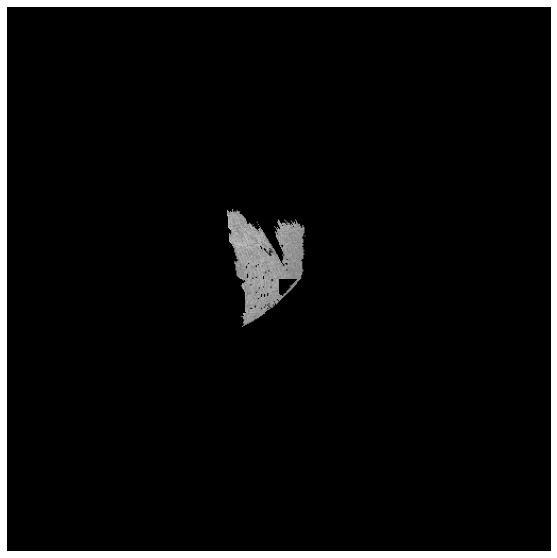

In [38]:
images = R(points)
print(images.shape)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [11]:
points.shape

torch.Size([1, 262144, 3])

In [22]:
points.expand(2, -1, -1).max(dim=1).values.shape

torch.Size([2, 3])

In [25]:
max_vals = points.min(dim=1).values
min_vals = points.max(dim=1).values
print(min_vals.shape, max_vals.shape)
min_vals, max_vals

torch.Size([1, 3]) torch.Size([1, 3])


(tensor([[0.1678, 0.2477, 0.1982]], device='cuda:0'),
 tensor([[-0.2283, -0.2022, -0.4638]], device='cuda:0'))

In [32]:
print(points.mean(dim=-2, keepdim=False).shape)
print(points.mean(dim=-2, keepdim=False))

torch.Size([1, 3])
tensor([[    -0.0000,     -0.0000,     -0.0000]], device='cuda:0')


In [28]:
(min_vals + max_vals) / 2

tensor([[-0.0302,  0.0228, -0.1328]], device='cuda:0')

In [24]:
import pytorch3d.transforms as T3


tm = points.mean(dim=-2, keepdim=False)
T = T3.Translate(-tm, device=points.device)            
points = T.transform_points(points)

torch.Size([1, 512, 512, 4])


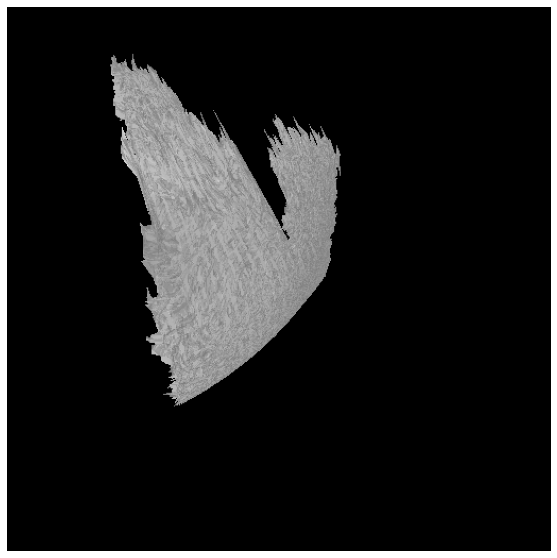

In [63]:
def get_min_max(points):
    return (points.min(dim=1).values,
            points.max(dim=1).values)

min_vals, max_vals = get_min_max(points)
tm = (min_vals + max_vals) / 2
T = T3.Translate(-tm, device=points.device)

sm = torch.zeros_like(tm) + (0.7 / (max_vals - min_vals)[:, :2]).min()

S = T3.Scale(sm, device=points.device)
TS = T3.Transform3d().compose(T, S).to(points.device)
t_points = TS.transform_points(points)

images = R(t_points)
print(images.shape)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [42]:
min_vals, max_vals, tm

(tensor([[ 0.1214, -0.5926,  0.1659]], device='cuda:0'),
 tensor([[ 0.3116, -0.3056,  0.6355]], device='cuda:0'),
 tensor([[ 0.2165, -0.4491,  0.4007]], device='cuda:0'))

In [48]:
1 / (max_vals - min_vals).abs()

tensor([[5.2564, 3.4842, 2.1295]], device='cuda:0')

In [65]:
normals.shape

torch.Size([1, 65536, 3])

In [68]:
normals.mean(dim=1)#.shape

tensor([[ 0.7543, -0.4059,  0.3149]], device='cuda:0')